# **Exploring $WZ$ Diboson Production with ATLAS Open Data**

This notebook guides you through the analysis of $WZ$ diboson production, specifically focusing on the final state with three leptons ($WZ → 3l$). Using ATLAS Open Data from proton-proton collisions at the Large Hadron Collider (LHC), you will apply event selection criteria to identify and analyze this process.
___

# ATLAS Open Data

ATLAS Open Data provides publicly available datasets recorded by the ATLAS experiment at the LHC. These datasets allow students and researchers to explore real high-energy physics data, applying analysis techniques similar to those used in professional research.

___

# What Are Notebooks?

Jupyter notebooks provide an interactive environment for combining live code execution, visualizations. This makes them an ideal platform for conducting and documenting particle physics analyses.

___




## The Goal: Identifying $WZ \rightarrow 3\ell$ Events

In this analysis, we aim to reconstruct the **WZ production process** in proton–proton collisions, where:

- A **W boson** decays into a lepton (electron or muon) and a neutrino.
- A **Z boson** decays into a pair of opposite-sign, same-flavor leptons.

This results in a final state with **three charged leptons and missing transverse energy**, which is the signature we target in our selection.

---

### Why is WZ production important?

In the Standard Model, the simultaneous production of a W and a Z boson is a key electroweak process. It allows us to:

- Study how W and Z bosons interact — especially through the **triple gauge coupling** \( WWZ \), which is a prediction of the electroweak theory.
- Search for **deviations from the Standard Model** that could hint at **new physics**, such as anomalous gauge couplings.
- Use the clean three-lepton final state (with little background and good reconstruction efficiency) for **precision measurements**.
- Understand backgrounds to other processes like **Higgs production**, **supersymmetry**, and other BSM scenarios.

---

### How are W and Z bosons produced?

At the LHC, the main way W and Z bosons are produced is through a process called the **s-channel production**.

In this process, a **quark and an antiquark** annihilate to form a **virtual W boson**, which then decays into a **real W and Z boson**:
  $q\bar{q} \rightarrow W^* \rightarrow WZ$

The Feynman diagram below illustrates this process:

![WZ s-channel diagram](images/WZimages/WZ_schan.png)

The key feature of this diagram is the interaction point where **three force particles meet** — two W bosons and one Z boson. This is called the **triple gauge coupling**, and it is a unique prediction of the Standard Model.

This makes WZ production an important process to test whether the Standard Model is correct, and to look for **signs of new physics** through possible small deviations.

---

### What happens after the W and Z are produced?

Once the W and Z bosons are created, they quickly **decay into leptons**, which are the particles we actually detect:

- The **W boson** decays into a **charged lepton** (electron or muon) and a **neutrino**:


  > $W^\pm \rightarrow \ell^\pm + \nu$  

![W to lepton + neutrino](images/WZimages/Wlv_decay.png)

- The **Z boson** decays into a pair of **opposite-sign, same-flavor leptons**:


  > $Z \rightarrow \ell^+ + \ell^-$
  
![Z to lepton + lepton](images/WZimages/Zll_decay.png)

Together, these decays lead to a **final state with three charged leptons and missing transverse energy** (due to the neutrino, which escapes the detector).

This is the signal we are looking for in our analysis.

___


# **Installing atlasopenmagic**

Atlas Open Magic is a Python package made to simplify working with ATLAS Open Data by providing utilities to manage metadata and URLs for streaming the data.

In [ ]:
#install required packages
!pip install atlasopenmagic
from atlasopenmagic import install_from_environment
install_from_environment()

# **Importing libraries**
We now import the necessary libraries for data manipulation, visualization, and access to ATLAS Open Data:

In [2]:
import numpy as np  # For efficient numerical operations, array handling, and histogramming
import matplotlib.pyplot as plt  # For plotting histograms, distributions, and other visualizations
import matplotlib_inline  # Ensures plots are rendered inline in Jupyter/Colab environments
from matplotlib.ticker import AutoMinorLocator  # Adds minor ticks to plot axes for better readability

import uproot  # Reads ROOT files (HEP data format) in pure Python, without needing the full ROOT framework
import awkward as ak  # Works with jagged/nested arrays (like lists of particles per event) efficiently in columnar format
import atlasopenmagic as atom  # Provides access to ATLAS Open Data metadata and streaming URLs
import requests # for HTTP access
import time  # For measuring execution time and profiling code blocks
import warnings


# Filter out any warnings that are expected, to avoid confusion while running
warnings.filterwarnings("ignore", message="invalid value encountered in sqrt")
warnings.filterwarnings("ignore", message="overflow encountered in power")
warnings.filterwarnings("ignore", message="overflow encountered in multiply", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="invalid value encountered in subtract")

# **Selecting the Data Release**
To begin working with ATLAS Open Data, we first list all available data releases and then select the one we want to use. This ensures that all subsequent metadata and file access requests are tied to the correct data version.

In [3]:
atom.available_releases()
atom.set_release('2025e-13tev-beta')

Available releases:
2016e-8tev        2016 Open Data for education release of 8 TeV proton-proton collisions (https://opendata.cern.ch/record/3860).
2020e-13tev       2020 Open Data for education release of 13 TeV proton-proton collisions (https://cern.ch/2r7xt).
2024r-pp          2024 Open Data for research release for proton-proton collisions (https://opendata.cern.record/80020).
2024r-hi          2024 Open Data for research release for heavy-ion collisions (https://opendata.cern.ch/record/80035).
2025e-13tev-beta  2025 Open Data for education and outreach beta release for 13 TeV proton-proton collisions (https://opendata.cern.ch/record/93910).
2025r-evgen       2025 Open Data for research release for event generation (https://opendata.cern.ch/record/160000).
Active release set to: 2025e-13tev-beta. Metadata cache cleared.


# **Explanation of Key Parameters**
In particle physics analyses, various parameters and constants are essential for accurately processing data and interpreting results.

* Integrated luminosity (lumi): is a measure of the total amount of data collected by a particle detector over a certain period. It represents the total number of potential collisions that could have occurred in a particle accelerator and is typically measured in inverse femtobarns .
Fraction of Events to Process

* fraction: this parameter controls what fraction of the available events in the dataset will be processed by the analysis in each iteration.

In [4]:
lumi = 36600 # This sample is 36.6 Inverse femtobarns (or 36600 Inverse picobarns)
fraction = 1 # Reduce this if you want your code to run faster

 # **Defining and Building MC and Data Samples**
 We now define the Monte Carlo (MC) and data samples used in this analysis, specifying which dataset IDs correspond to different physics processes(signal and various background categories), and filtered to only include events with exactly three leptons.

In [5]:
defs = {
    r'Data':      {'dids':['data']},
    r'Signal':    {'dids': [700601]},

    r'Diboson':   {'dids': [700493,700488,700492,700600]},

    r'Vjets':     {'dids': [700323,700324,700325,700470,700320,700321,700322,
                            700792,700793,700794,700341,700342,700343,700344,
                            700345,700346,700347,700348,700349,700338,700339,700340]},

    r'other':     {'dids': [410470,410644,410645,410658,410659,601355,601352]},
}

# Build dataset with skim: only events with exactly 3 leptons
samples = atom.build_dataset(defs, skim='exactly3lep', protocol='https', cache=True)

Fetching and caching all metadata for release: 2025e-13tev-beta...
Successfully cached 374 datasets.


# **Applying Event Weights in the Analysis**
To accurately compare simulated events to real collision data, we apply event weights. These weights account for various factors such as:

* Pileup corrections: Adjustments for the modeling of additional collisions in the same event.

* Lepton scale factors: Corrections for electron and muon identification, reconstruction, and trigger efficiencies.

* Monte Carlo normalization: Scaling based on cross-sections, k-factors, and filtering efficiencies.

By applying event weights, we ensure that simulated samples accurately represent the expected event yields in real LHC data. The following function calculates the total event weight used in this analysis.

In [6]:
def calc_weight(data):

    scale_factors = (data["ScaleFactor_PILEUP"] * data["ScaleFactor_ELE"] * data["ScaleFactor_MUON"] * data["ScaleFactor_MLTRIGGER"])

    norm_factor = (data["xsec"] * data["kfac"] * data["filteff"]) / data["sum_of_weights"]

    weight = data["mcWeight"] * scale_factors * norm_factor * lumi

    return weight

# **Applying Dilepton Trigger Selection in the Analysis**
In high-energy physics experiments like ATLAS, triggers play a crucial role in selecting events of interest while efficiently handling large data volumes.

For this analysis, we apply dilepton triggers, which are designed to fire when an event contains at least two leptons (electrons or muons) that pass certain kinematic and identification criteria. We consider two categories of dilepton triggers:

* Electron-based dilepton triggers (trigDE): Fire when two electrons satisfy the trigger conditions.

* Muon-based dilepton triggers (trigDM): Fire when two muons satisfy the trigger conditions.

In [7]:
def cut_trig(trigDE,trigDM):
    return trigDE | trigDM

# **Matching Leptons to Dilepton Triggers**
In this analysis, we use dilepton triggers, which fire when an event contains at least two leptons that satisfy specific selection criteria. However, not all reconstructed leptons in an event necessarily contributed to the trigger decision. To ensure that at least one of the selected leptons was responsible for firing the trigger, we apply a trigger-matching condition.

The variable trigML indicates whether a lepton is matched to the dilepton trigger:

* trigML = 1 → The lepton is matched to the dilepton trigger.

* trigML = 0 → The lepton is not matched to the trigger.

To ensure that we only select events where at least one lepton was responsible for firing the dilepton trigger, we apply the following condition:

In [8]:
def cut_match_MLtrig(trigML):
    return trigML==1

# **Selecting Events with Exactly Three Leptons**
In the $WZ → 3l$ analysis, we focus on events containing exactly three leptons. This requirement is crucial because:

* The $W$ boson decays into a lepton (electron or muon) and a neutrino.

* The $Z$ boson decays into a pair of same-flavor, opposite-sign (SFOS) leptons.

By enforcing this selection, we remove events with fewer or more leptons, which are unlikely to originate from $WZ$ production. The function below ensures that only events with exactly three leptons are retained for further analysis.

In [9]:
def three_lep(lep_n):
    return lep_n == 3

# **Missing Transverse Energy (MET) Requirement**
In $WZ → 3l$ events, the W boson decays into a lepton and a neutrino. Since neutrinos do not interact with the ATLAS detector, they escape detection, leading to missing transverse energy.

To ensure that selected events contain a neutrino, we apply a minimum **MET** threshold. This cut helps reduce backgrounds from processes without genuine neutrinos, such as $Z+jets$, where **MET** arises from mismeasurements.

The function below applies a **MET** cut to retain events with significant missing energy, improving the purity of the $WZ$ selection.

In [10]:
def cut_met_et(met_et):
    return met_et > 30

# **Lepton Transverse Momentum ($P_T$) Selection**
Transverse momentum ($P_T$) is a crucial variable in event selection, as it helps ensure that the leptons are well-reconstructed and distinguishable from, low-energy background particles.

For the $WZ → 3l$ analysis, we apply two conditions to the lepton $P_T$:

  1. At least three leptons must have $P_T > 20 GeV$ to guarantee all leptons are energetic enough for accurate reconstruction.

  2. At least one lepton must have $P_T > 25 GeV$ to ensure a high-momentum lepton, improving trigger efficiency.

These cuts enhance the signal purity while maintaining high efficiency for $WZ$ event selection. The function below implements these requirements.

In [11]:
def cut_lep_pt(lep_pt):
    pt = lep_pt
    cut1 = ak.sum(pt > 20, axis=1) > 2
    cut2 = ak.sum(pt > 25, axis=1) >= 1
    return cut1 & cut2

# **Lepton Identification and Isolation Requirement**
Lepton Isolation Selection (Track and Calorimeter)

In electroweak processes like $WZ → 3ℓ$, leptons are typically isolated from other particle activity,
whereas background leptons (e.g. from heavy flavor decays or jets faking leptons) are often surrounded by nearby tracks or energy deposits. To distinguish these, we apply two types of isolation cuts:
 1. **Track Isolation** (`pt_cone`): Measures the sum of transverse momenta of tracks around the lepton.
 2. **Calorimeter Isolation** (`et_cone`): Measures the sum of transverse energy deposits in the calorimeter near the lepton.

For both types, we use the ratio of isolation energy to lepton transverse momentum (`iso / pt`).
A ratio below 0.15 indicates the lepton is well-isolated.
In each case, the event is kept only if **more than two leptons** satisfy `iso / pt < 0.15`.
This ensures that all three leptons in the WZ → 3ℓ event are likely prompt, clean, and isolated.

In [12]:
def cut_track_iso(pt_cone, pt):
    cut = ak.sum(np.abs(pt_cone/pt) < 0.15, axis=1) > 2
    return cut

In [13]:
def cut_cal_iso(et_cone, pt):
    cut = ak.sum(np.abs(et_cone/pt) < 0.15, axis=1) > 2
    return cut

# **Lepton Selection: Tight ID with Loose Isolation**

In this step, we apply a combined selection that uses:

  1. **Tight Identification (ID):** Ensures leptons are of high quality — consistent with prompt,
     well-reconstructed leptons from the primary vertex (not fakes or from hadron decays).
  2. **Loose Isolation (iso):** Allows some nearby detector activity around the lepton.

This improves efficiency (especially in busy events) while still rejecting most background.

The function checks whether each lepton satisfies both conditions (`ID & iso`) and then counts how many such leptons exist in each event.

The event is selected only if **more than two leptons** pass both tight ID and loose isolation. This is a common strategy in WZ → 3ℓ analyses, where the goal is to retain high signal efficiency without compromising much on background rejection.

In [14]:
def ID_iso_cut(ID,iso):
    return ak.sum(ID & iso,axis=1) > 2

# **Same-Flavor Opposite-Sign (SFOS) Lepton Pair Selection**
In the $WZ → 3ℓ$ analysis, identifying a same-flavor opposite-sign (SFOS) lepton pair is crucial for reconstructing the Z boson. The $Z$ boson decays into an electron-positron ($e^-e^+$) or muon-antimuon ($μ^-μ^+$) pair, so we need to:


*   Select lepton pairs with the same flavor (both electrons or both muons)
*   Ensure the selected pair has opposite charges (one positively and one negatively charged lepton)

This step is essential to distinguish real $Z$ boson decays from background processes where lepton pairs may arise from other sources. The function below applies these conditions to each event to retain only those with at least one valid SFOS lepton pair.

In [15]:
def sfos_pair(flavor, charge):

    # Generate all unique pairs of particles for each event
    # Combinations of 2 ensure no particle is compared with itself
    f_pairs = ak.combinations(flavor, 2, fields=["flavor_0", "flavor_1"])
    c_pairs = ak.combinations(charge, 2, fields=["charge_0", "charge_1"])

    # Same-flavor check: both particles in the pair must be of the same type
    same_flavor = f_pairs.flavor_0 == f_pairs.flavor_1

    # Opposite-sign check: the charges of the particles must be different
    opposite_sign = c_pairs.charge_0 != c_pairs.charge_1

    # Find where both conditions are met
    sfos = same_flavor & opposite_sign

    # We want at least one SFOS pair per event
    sfos_cut = ak.any(sfos, axis=1)

    return sfos_cut

# **Lepton Four-Momentum Packaging**
For the WZ → 3ℓ analysis, we need to package the leptons into four-momentum vectors to facilitate further calculations, such as reconstructing invariant masses and analyzing kinematic variables. The four-momentum of a particle is defined by its energy ($E$) and momentum components ($p_x, p_y, p_z$).

The function below converts the lepton's transverse momentum ($p_t$), pseudorapidity ($η$), and azimuthal angle ($φ$) into the full momentum components in three dimensions ($p_x, p_y, p_z$), and packages this information into a structured format that can be used for further analysis. It also includes the missing transverse energy ($MET$) and $MET_{\text{phi}}$, which are important for the $W$ boson reconstruction.

In [16]:
def package_leptons(flavor, charge, E, pt, eta, phi, met, met_phi):
    lep_px = pt * np.cos(phi)
    lep_py = pt * np.sin(phi)
    lep_pz = pt / np.tan(2.0 * np.arctan(np.exp(-eta)))

    leptons = ak.zip({
        "flavor": flavor,
        "charge": charge,
        "E": E,
        "pt": pt,
        "eta": eta,
        "phi": phi,
        "px": lep_px,
        "py": lep_py,
        "pz": lep_pz,
        "met": met,
        "met_phi": met_phi,
    })

    return leptons

# **Finding the Closest SFOS Pair to the $Z$ Boson Mass**
Each event may have more than one SFOS lepton pair , so selecting the correct SFOS pair that reconstructs the $Z$ boson mass is a critical step. The function below identifies the lepton pair closest to the $Z$ boson mass (around $91 GeV$) from a set of SFOS pairs. This is done by calculating the invariant mass of each pair and selecting the one with the smallest difference from the $Z$ mass.

The process involves:


1.   Creating lepton pairs: All unique pairs of leptons from the event are generated.
2.   Applying the SFOS condition: Only pairs that are of the same flavor (e.g., both electrons or both muons) and opposite sign (i.e., opposite charges) are kept.
3. Calculating the invariant mass of each SFOS pair: The four-momentum is used to calculate the invariant mass of each pair.
4. Finding the pair closest to the $Z$ boson mass: The mass difference between the calculated invariant mass of each SFOS pair and the nominal $Z$ boson mass is calculated. The pair with the smallest mass difference is selected.
5. Returning the selected leptons: The two leptons that form the SFOS pair closest to the $Z$ mass, along with the invariant mass of the pair, are returned.

In [17]:
def find_closest_sfos_pair(leptons):
    z_mass = 91.0
    z_window = 10.0


    # Create all unique lepton pairs
    lep_pairs = ak.combinations(leptons, 2, fields=["lep1", "lep2"])

    # SFOS condition
    same_flavor = lep_pairs.lep1.flavor == lep_pairs.lep2.flavor
    opposite_sign = lep_pairs.lep1.charge != lep_pairs.lep2.charge
    sfos_mask = same_flavor & opposite_sign

    # Filter SFOS pairs
    sfos_pairs = lep_pairs[sfos_mask]

    # Compute invariant mass of SFOS pairs
    E_sum = sfos_pairs.lep1.E + sfos_pairs.lep2.E
    px_sum = sfos_pairs.lep1.px + sfos_pairs.lep2.px
    py_sum = sfos_pairs.lep1.py + sfos_pairs.lep2.py
    pz_sum = sfos_pairs.lep1.pz + sfos_pairs.lep2.pz

    masses = np.sqrt(E_sum**2 - (px_sum**2 + py_sum**2 + pz_sum**2))

    # Compute absolute difference from Z mass
    mass_diff = np.abs(masses - z_mass)

    # Create a mask for the pair closest to the Z boson mass
    closest_mask = mass_diff == ak.min(mass_diff, axis=1)

    # Use boolean mask to select the closest SFOS pair
    closest_pair = sfos_pairs[closest_mask]
    closest_mass = masses[closest_mask]

    selected_lep1 = closest_pair.lep1
    selected_lep2 = closest_pair.lep2


    return selected_lep1, selected_lep2, closest_mass

# **$Z$ Boson Mass Cut**
In the analysis of the $WZ → 3l$ process, we need to identify the leptons that are consistent with the decay of a $Z$ boson. The $Z$ boson decays into a pair of same-flavor, opposite-sign leptons, and we expect the invariant mass of this lepton pair to be close to the known mass of the $Z$ boson (around $91 GeV$).  This uses the same 10 GeV mass window as the previous function.

To ensure we are selecting lepton pairs consistent with this decay, we apply a cut to select only those pairs whose mass falls within the typical $Z$ boson mass window ($81 GeV < mass < 101 GeV$).

This cut is crucial for rejecting background events and selecting signal events where the invariant mass of the lepton pair matches the expected mass of the $Z$ boson. The function returns a boolean array indicating whether each event passes this mass cut.

In [18]:
def z_boson_cut(closest_mass):
    # Z mass window cut: 81 < mass < 101
    z_mass_cut_mask = (closest_mass > 81) & (closest_mass < 101)
    z_mass_cut = ak.any(z_mass_cut_mask, axis=1)
    return z_mass_cut

# **Splitting SFOS Pairs by flavor**

After selecting the closest same-flavor opposite-sign (SFOS) lepton pair, it's useful to categorize these pairs by their lepton flavor (electron or muon). This step ensures we handle the different lepton flavors separately.

This function splits the closest SFOS pairs into two categories:

1. Electron pairs ($ee$): Pairs where both leptons are electrons (flavor code 11).

2. Muon pairs ($μμ$): Pairs where both leptons are muons (flavor code 13).

The function performs the following:

* It checks whether the lepton pair consists of two electrons or two muons.


* It then creates separate arrays for the invariant mass of the SFOS pairs, depending on whether the pair is electron-electron ($e^-e^+$) or muon-muon ($μ^-μ^+$).


In [19]:
def split_sfos_pairs(paired_lep1, paired_lep2, closest_mass):

    is_ee = (paired_lep1.flavor == 11) & (paired_lep2.flavor == 11)
    is_mm = (paired_lep1.flavor == 13) & (paired_lep2.flavor == 13)

    closest_ee_mass = ak.mask(closest_mass, is_ee)
    closest_mumu_mass = ak.mask(closest_mass, is_mm)

    return closest_ee_mass, closest_mumu_mass

# **Identifying the Unpaired Lepton**
In events with exactly three leptons, we need to identify which lepton is unpaired, meaning it is not part of the selected same-flavor opposite-sign (SFOS) pair. This step is crucial for reconstructing the $W$ boson, as the unpaired lepton corresponds to the decay product of the $W$ boson, while the SFOS pair corresponds to the $Z$ boson.

The function operates as follows:

1. It extracts the individual leptons from the set of three leptons in the event.

2. It then checks which lepton is not part of the selected SFOS pair by comparing the transverse momentum ($p_T$) of each lepton to those of the two paired leptons.

3. The lepton that is not part of the SFOS pair is identified as the unpaired lepton.

The function uses the ak.where function to apply these conditions and returns the unpaired lepton, which will later be used for reconstructing the $W$ boson mass.

In [20]:
def find_unpaired_lepton(leptons, paired_lep1, paired_lep2):
    # Extract individual leptons
    lep1, lep2, lep3 = leptons[:, 0], leptons[:, 1], leptons[:, 2]

    # Identify the unpaired lepton
    unpaired_lepton = ak.where(
        (lep1.pt != paired_lep1.pt) & (lep1.pt != paired_lep2.pt), lep1,
        ak.where((lep2.pt != paired_lep1.pt) & (lep2.pt != paired_lep2.pt), lep2, lep3)
    )

    return unpaired_lepton

# **Calculating the Transverse Mass of the $W$ Boson**
The transverse mass of the W boson is a key quantity in reconstructing the W boson in $WZ → 3l$ events. The full momentum of the neutrino is not known. Through momentum balance, its transverse momentum (momentum in x and y) can be determined from the rest of the event. The transverse mass uses this transverse momentum instead of the full momentum vector to calculate a mass. Instead of having a sharp peak at the mass of the W boson, it is expected to have a broader distribution that falls off sharply around the mass of the W boson. This function computes the transverse mass using the unpaired lepton and missing transverse energy ($MET$).

  The transverse mass is calculated using the formula:
  $m_T^2 = \left( p_T^{\text{lep}} + p_T^{\text{MET}} \right)^2 - \left( p_X^{\text{lep}} + p_X^{\text{MET}} \right)^2 - \left( p_Y^{\text{lep}} + p_Y^{\text{MET}} \right)^2$


In [21]:
def w_boson_mass(unpaired_lepton):

    # Convert from MeV to GeV
    lep_pt = unpaired_lepton.pt
    lep_phi = unpaired_lepton.phi
    lep_px = unpaired_lepton.px
    lep_py = unpaired_lepton.py
    met_et = unpaired_lepton.met
    met_phi = unpaired_lepton.met_phi
    # Calculate the transverse components (px and py) of the lepton and MET
    lep_px = lep_pt * np.cos(lep_phi)
    lep_py = lep_pt * np.sin(lep_phi)
    met_px = met_et * np.cos(met_phi)
    met_py = met_et * np.sin(met_phi)

    # Calculate the transverse mass of the W boson
    w_mt_squared = ((lep_pt + met_et)**2 - ((lep_px + met_px)**2 + (lep_py + met_py)**2))
    w_mt_squared = np.maximum(w_mt_squared, 0)  # Set negative values to zero
    w_mt = np.sqrt(w_mt_squared)

    return w_mt

# **$W$ boson mass cut**
The function below filters out events where the transverse mass is below a certain threshold ($30 GeV$). This cut ensures that only events with a significant transverse mass are retained for further analysis, improving the signal-to-background ratio.

In [22]:
def w_boson_cut(w_mt):

    w_mass_cut_mask = w_mt > 30
    w_mass_cut = ak.any(w_mass_cut_mask, axis=1)

    return w_mass_cut

# **Splitting the $W$ boson by lepton type**
 The function below splits the transverse mass values ($M_T^W$) into two arrays: one for events with a muon as the unpaired lepton and one for events with an electron. This separation allows for more precise analysis of each channel (muon and electron), as their characteristics and response in the detector are distinct.

In [23]:
def split_by_type(w_mt, unpaired_lepton):

    # Create masks for muons and electrons
    is_muon = unpaired_lepton.flavor == 13
    is_electron = unpaired_lepton.flavor == 11

    # Use the mask to filter w_mt for muons and electrons
    w_mt_muon = ak.mask(w_mt, is_muon)
    w_mt_electron = ak.mask(w_mt, is_electron)

    return w_mt_muon, w_mt_electron

# **Event Selection and Data Processing**

This section processes Monte Carlo (MC) and real data samples to study the $WZ → 3l$ process. It applies event selection criteria and computes relevant observables to identify signal events and suppress background contributions.

## Overview of the Processing Steps

### 1. Define Input Variables
A list of variables is specified to be extracted from the ROOT files. These include:

- **Lepton properties**: kinematics (`lep_pt`, `lep_eta`, `lep_phi`, `lep_e`), charge, type, identification, and isolation
- **Trigger decisions**: di-lepton triggers and matching
- **Event-level information**: missing transverse energy (`met`), pileup, scale factors, and weights

These variables are critical for reconstructing physics objects (e.g. leptons, missing energy) and applying selection criteria.

### 2. Outer Loop — Sample-Level Processing
Each sample (`s`) is processed separately. This loop:
- Iterates over both MC and real data samples
- Determines if a file is MC or data based on naming and directory structure
- Prepares to store the processed output in a dictionary (`all_data`) for later use

### 3. Middle Loop — File-Level Processing
For each sample, the code loops over all associated ROOT files listed in `samples[s]['list']`:
- Opens the file and accesses the `analysis` TTree
- Reads data in manageable chunks using `uproot.iterate`, which allows large datasets to be processed efficiently

### 4. Inner Loop — Event Chunk Processing
Each chunk of events undergoes the following sequence of operations:

#### a. Event Selection Cuts
A series of physics-motivated selection functions are applied:
- **Trigger Cut**
- **Trigger Matching**
- **MET Cut**
- **Lepton Multiplicity**
- **Lepton \( p_T \)** Cut
- **Lepton Identification**
- **Calorimeter and Track Isolation**
- **SFOS Pair Requirement**
- **Z Boson Mass cut**
- **W Boson Transverse Mass cut**

Only events passing these conditions conditions are retained.

#### b. Reconstruct Physics Objects
From selected events, derived quantities are computed:
- **Lepton Packaging**
- **SFOS Pairing**
- **Z Boson Candidate**
- **Unpaired Lepton Identification**
- **W Boson Candidate**



#### c. Save New Variables
The following new quantities are added to the dataset:
- `wtmass`, `zmass`
- `ee_pair_mass`, `mumu_pair_mass`
- `wmuon`, `welectron`

#### d. Calculate Event Weights (MC only)
If the sample is MC, a total weight (`totalWeight`) is calculated.

### 5. Concatenation
- All chunks (`sample_data`) are concatenated using `ak.concatenate`
- After all files for a sample are processed, the complete sample is stored in `all_data[s]`
- The final dictionary `all_data` contains one entry per sample (e.g., `data`, `Signal`, `Diboson`, `Vjets`, `Other`), each holding an Awkward Array of selected and computed event-level data ready for further analysis.




In [24]:
# Define the list of variables to load from each ROOT file.
# These include MC weights, scale factors, trigger info, lepton properties, MET, etc.
variables = [
    "mcWeight", "sum_of_weights", "ScaleFactor_ELE", "ScaleFactor_MUON", "ScaleFactor_MLTRIGGER",
    "ScaleFactor_PILEUP", "xsec", "filteff", "kfac", "trigDE", "trigDM", "TriggerMatch_DILEPTON",
    "lep_isTightID", "lep_isLooseIso", "lep_topoetcone20", "lep_ptvarcone30", "lep_n", "lep_pt",
    "lep_eta", "lep_phi", "lep_charge", "lep_type", "met", "met_phi", "lep_e"
]

# Dictionary to store final processed data for each sample (e.g. 'WZ', 'ZZ', 'data')
all_data = {}

# Start a timer to measure how long the full data processing takes
start_all = time.time()

# Loop over all samples (MC or data) defined in the `samples` dictionary
for s in samples:
    frames = []  # List to collect processed data chunks from each file in this sample

    # Loop over ROOT files associated with the current sample
    for val in samples[s]['list']:
        # Accessing the file from the online database (":analysis" opens the tree in a desired manner)
        tree = uproot.open(val + ":analysis") 

        sample_data = []  # Store processed chunks from this file

        # Iterate over chunks of events from the ROOT tree (up to a fraction of the total)
        for data in tree.iterate(variables, library="ak", entry_stop=tree.num_entries * fraction):
            # Apply physics-motivated event selection cuts in sequence
            data = data[cut_trig(data.trigDE, data.trigDM)]
            data = data[cut_match_MLtrig(data.TriggerMatch_DILEPTON)]
            data = data[cut_met_et(data.met)]
            data = data[three_lep(data.lep_n)]
            data = data[cut_lep_pt(data.lep_pt)]
            data = data[ID_iso_cut(data.lep_isTightID, data.lep_isLooseIso)]
            data = data[cut_cal_iso(data.lep_topoetcone20, data.lep_pt)]
            data = data[cut_track_iso(data.lep_ptvarcone30, data.lep_pt)]
            data = data[sfos_pair(data.lep_type, data.lep_charge)]

            # Organize leptons into structured objects for further analysis
            leptons = package_leptons(
                data.lep_type, data.lep_charge, data.lep_e,
                data.lep_pt, data.lep_eta, data.lep_phi,
                data.met, data.met_phi
            )

            # Identify the SFOS pair with invariant mass closest to the Z mass
            paired_lep1, paired_lep2, closest_mass = find_closest_sfos_pair(leptons)

            # Extract specific ee and μμ SFOS masses for histogramming
            ee_mass, mumu_mass = split_sfos_pairs(paired_lep1, paired_lep2, closest_mass)

            # Identify the unpaired lepton and compute transverse mass of W boson
            unpaired_lepton = find_unpaired_lepton(leptons, paired_lep1, paired_lep2)
            w_mt = w_boson_mass(unpaired_lepton)

            # Separate W candidates based on lepton type (electron or muon)
            w_mt_muon, w_mt_electron = split_by_type(w_mt, unpaired_lepton)

            # Apply mass window cuts around Z and W boson expected values
            z_mask = z_boson_cut(closest_mass)
            w_mask = w_boson_cut(w_mt)
            combined_mask = z_mask & w_mask

            # Keep only events passing both mass window selections
            data = data[combined_mask]

            # Add computed quantities to the dataset
            data['wtmass'] = w_mt[combined_mask]
            data['zmass'] = closest_mass[combined_mask]
            data['ee_pair_mass'] = ee_mass[combined_mask]
            data['mumu_pair_mass'] = mumu_mass[combined_mask]
            data['wmuon'] = w_mt_muon[combined_mask]
            data['welectron'] = w_mt_electron[combined_mask]
            
            # We are only keeping the variables that we will plot. You can add more here, 
            # but it will take longer to run and use more memory
            to_keep = ["met", "wtmass", "wmuon", "welectron", "zmass", "mumu_pair_mass", "ee_pair_mass"]
            # For MC only, compute and store the total event weight
            if 'data' not in s:
                data['totalWeight'] = calc_weight(data)
                to_keep.append("totalWeight")

            # Append processed data from the current file to the list
            data = data[to_keep]
            sample_data.append(data)

        # Concatenate all data from the current sample file into a single array
        frames.append(ak.concatenate(sample_data))

    # Concatenate all files for this sample into one final array and store in dictionary
    all_data[s] = ak.concatenate(frames)

# Stop timer and print total time taken
end_all = time.time()
print(f"\nTotal time taken to process all samples: {round((end_all - start_all) / 60, 1)} minutes")


Total time taken to process all samples: 5.4 minutes


# **Plotting**


In [25]:
def plot_data(data, xmin, xmax, step_size, x_label, y_label, data_mc, mc_Weight, data_di,
              di_Weight, data_vjets, vjets_Weight, data_other, other_Weight):
    # Define MC data sets and their properties
    datasets = [
        {'data': data_vjets, 'weights': vjets_Weight, 'color': 'green', 'label': r'V+jets'},
        {'data': data_other, 'weights': other_Weight, 'color': 'orange', 'label': r'OTHER'},
        {'data': data_di, 'weights': di_Weight, 'color': 'slateblue', 'label': r'ZZ,WW'},
        {'data': data_mc, 'weights': mc_Weight, 'color': 'lightcoral', 'label': r'WZ'},
    ]

    # Create bin edges
    bin_edges = np.arange(xmin, xmax + step_size, step_size)

    # Convert data to numpy for histogramming
    data_np = ak.to_numpy(data)

    # Handle overflow: add events > xmax to the last bin
    data_np[data_np > xmax] = xmax

    # Histogram the data
    data_x, _ = np.histogram(data_np, bins=bin_edges)
    data_x_errors = np.sqrt(data_x)  # Statistical error on the data

    # Mask bins with zero events
    mask_nonzero = data_x > 0
    bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2
    masked_centres = bin_centres[mask_nonzero]
    masked_data_x = data_x[mask_nonzero]
    masked_data_x_errors = data_x_errors[mask_nonzero]

    # Create main plot and residual subplot
    fig, (main_axes, residual_axes) = plt.subplots(2, 1, figsize=(7, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

    # Plot data with error bars
    main_axes.errorbar(x=masked_centres, y=masked_data_x, yerr=masked_data_x_errors,
                       fmt='ko', label='Data')

    # Adjust MC datasets for overflow handling
    for dataset in datasets:
        dataset['data'] = ak.to_numpy(dataset['data'])
        dataset['data'][dataset['data'] > xmax] = xmax

    # Plot stacked MC histograms
    mc_heights = main_axes.hist([d['data'] for d in datasets], bins=bin_edges,
                                weights=[d['weights'] for d in datasets], stacked=True,
                                color=[d['color'] for d in datasets], label=[d['label'] for d in datasets])

    # Extract total stacked MC from the last histogram
    mc_x_tot = mc_heights[0][-1]

    # Set up main axes
    main_axes.set_xlim(left=xmin, right=xmax)
    ymax = max(np.max(data_x), np.max(mc_x_tot))
    main_axes.set_ylim(0, ymax * 1.4)

    main_axes.xaxis.set_minor_locator(AutoMinorLocator())
    main_axes.tick_params(which='both', direction='in', top=True, right=True)
    main_axes.set_ylabel(y_label, y=1, horizontalalignment='right')
    main_axes.yaxis.set_minor_locator(AutoMinorLocator())

    # Add text to the plot
    main_axes.text(0.05, 0.93, 'ATLAS Open Data', transform=main_axes.transAxes, fontsize=13)
    main_axes.text(0.05, 0.88, 'for education', transform=main_axes.transAxes, style='italic', fontsize=8)
    main_axes.text(0.05, 0.82, r'$\sqrt{s}$=13 TeV, 36.6 fb$^{-1}$', transform=main_axes.transAxes)
    main_axes.text(0.05, 0.76, r'$W Z \rightarrow \ell \ell \ell ν$', transform=main_axes.transAxes)

    # Compute and show event counts
    total_events = np.count_nonzero(~np.isnan(data_np))
    main_axes.text(0.70, 0.65, f'Data Events: {total_events}', transform=main_axes.transAxes, fontsize=11)

    main_axes.legend(frameon=False)


    # Plot residuals with suppressed warnings for invalid division
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = data_x / mc_x_tot
        ratio_error = np.zeros_like(ratio)
        nonzero_mask = data_x > 0
        ratio_error[nonzero_mask] = ratio[nonzero_mask] * data_x_errors[nonzero_mask] / data_x[nonzero_mask]

    residual_axes.errorbar(bin_centres, ratio, yerr=ratio_error, fmt='ko')
    residual_axes.axhline(1, color='r', linestyle='--')
    residual_axes.set_ylim(0.5, 1.5)
    residual_axes.set_xlabel(x_label, fontsize=13, x=1, horizontalalignment='right')
    residual_axes.set_ylabel('Ratio (Data/MC)')
    residual_axes.xaxis.set_minor_locator(AutoMinorLocator())
    residual_axes.yaxis.set_minor_locator(AutoMinorLocator())
    residual_axes.tick_params(which='both', direction='in', top=True, right=True)

    # Adjust layout
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.05)

    plt.show()

# **Mass and Kinematic Distributions**

The plot_data() function is used to generate histograms for various variables from the all_data dictionary. For each histogram, it compares data with several MC samples (Signal, Diboson, Vjets, and other).

These plots help validate event selection and study discriminating features
between data, expected signal, and background processes.


The `plot_data` function is called to produce histograms for the following:

1. **Missing Transverse Energy ($MET$)**:
  - Variable: "missing_Et"
  - Range: [0, 160] GeV, 8 bins
  - X-axis: "$E_T^{\mathrm{miss}}$ [GeV]"










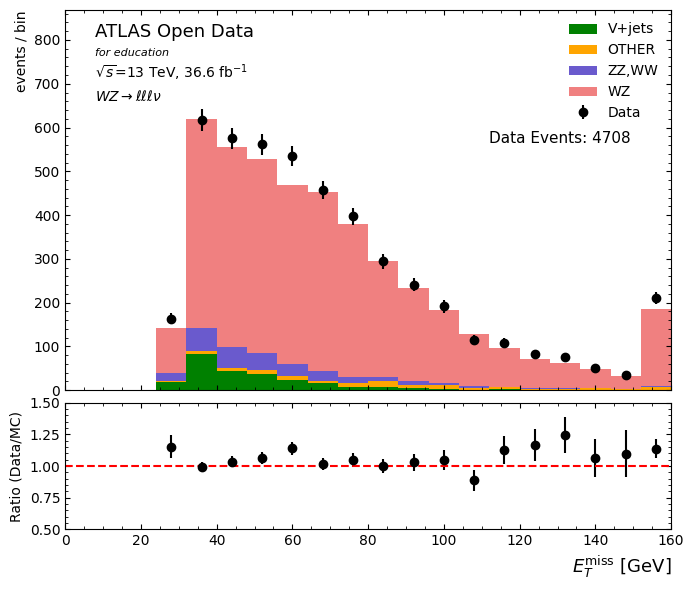

In [26]:
plot_data(
    np.hstack(all_data['Data']['met']), 0, 160, 8, r"$E_T^{\mathrm{miss}}$ [GeV]", "events / bin",
    np.hstack(all_data['Signal']['met']), np.hstack(all_data['Signal']['totalWeight']),
    np.hstack(all_data['Diboson']['met']), np.hstack(all_data['Diboson']['totalWeight']),
    np.hstack(all_data['Vjets']['met']), np.hstack(all_data['Vjets']['totalWeight']),
    np.hstack(all_data['other']['met']), np.hstack(all_data['other']['totalWeight'])
)

2. **Transverse Mass of W Boson ($W → lν$)**:
  - Variable: "W_tmass"
  - Range: [0, 200] GeV, 10 GeV bins
  - X-axis: "$M_T^{\mathrm{W}}$ [GeV]"

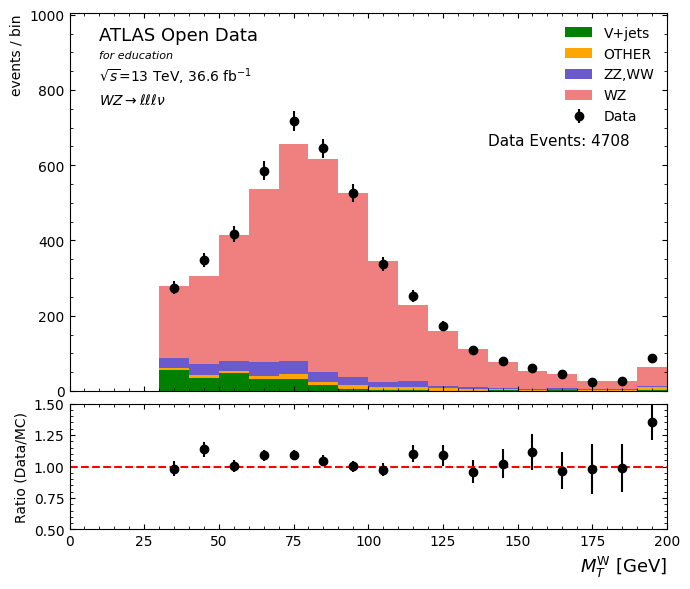

In [27]:
plot_data(
    np.hstack(all_data['Data']['wtmass']), 0, 200, 10, r"$M_T^{\mathrm{W}}$ [GeV]", "events / bin",
    np.hstack(all_data['Signal']['wtmass']), np.hstack(all_data['Signal']['totalWeight']),
    np.hstack(all_data['Diboson']['wtmass']), np.hstack(all_data['Diboson']['totalWeight']),
    np.hstack(all_data['Vjets']['wtmass']), np.hstack(all_data['Vjets']['totalWeight']),
    np.hstack(all_data['other']['wtmass']), np.hstack(all_data['other']['totalWeight'])
)

3. **W Boson Mass from Muon Channel ($W → μν$)**:
  - Variable: "w_muon"
  - Range: [0, 200] GeV, 10 GeV bins
  - X-axis: "$W_μ^{\mathrm{mass}}$ [GeV]"

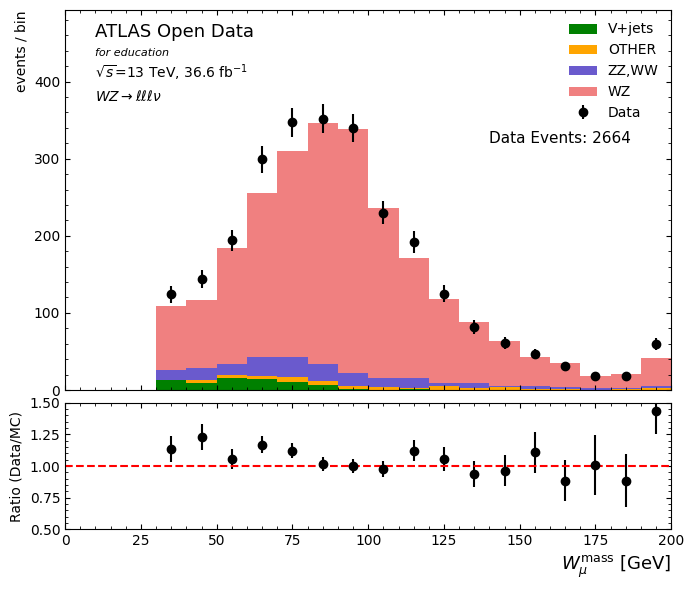

In [28]:
plot_data(
    np.hstack(all_data['Data']['wmuon']), 0, 200, 10, r"$W_μ^{\mathrm{mass}}$ [GeV]", "events / bin",
    np.hstack(all_data['Signal']['wmuon']), np.hstack(all_data['Signal']['totalWeight']),
    np.hstack(all_data['Diboson']['wmuon']), np.hstack(all_data['Diboson']['totalWeight']),
    np.hstack(all_data['Vjets']['wmuon']), np.hstack(all_data['Vjets']['totalWeight']),
    np.hstack(all_data['other']['wmuon']), np.hstack(all_data['other']['totalWeight'])
)

4. **W Boson Mass from Electron Channel ($W → eν$)**:
  - Variable: "w_electron"
  - Range: [0, 200] GeV, 10 GeV bins
  - X-axis: "$W_e^{\mathrm{mass}}$ [GeV]"

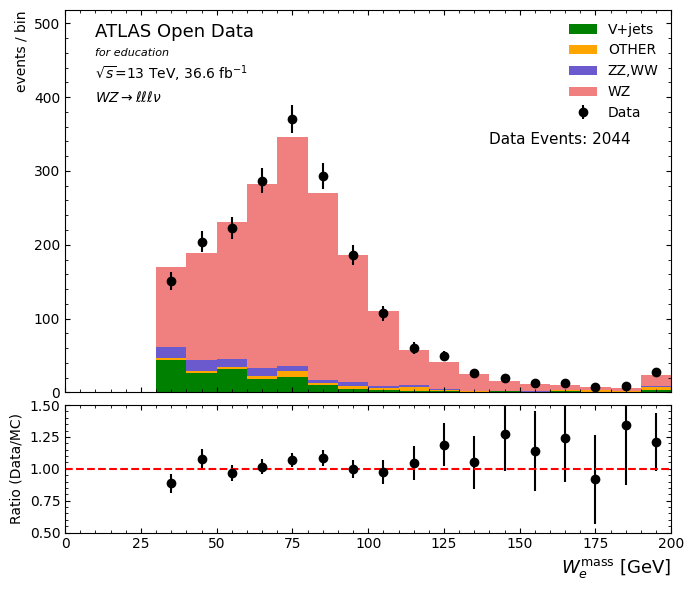

In [29]:
plot_data(
    np.hstack(all_data['Data']['welectron']), 0, 200, 10, r"$W_e^{\mathrm{mass}}$ [GeV]", "events / bin",
    np.hstack(all_data['Signal']['welectron']), np.hstack(all_data['Signal']['totalWeight']),
    np.hstack(all_data['Diboson']['welectron']), np.hstack(all_data['Diboson']['totalWeight']),
    np.hstack(all_data['Vjets']['welectron']), np.hstack(all_data['Vjets']['totalWeight']),
    np.hstack(all_data['other']['welectron']), np.hstack(all_data['other']['totalWeight'])
)

5. **Invariant Mass of $Z$ Candidate from SFOS Lepton Pair**:
  - Variable: "Z_mass"
  - Range: [75, 105] GeV, 1.5 GeV bins
  - X-axis: "$M_{ll}$ [GeV]"


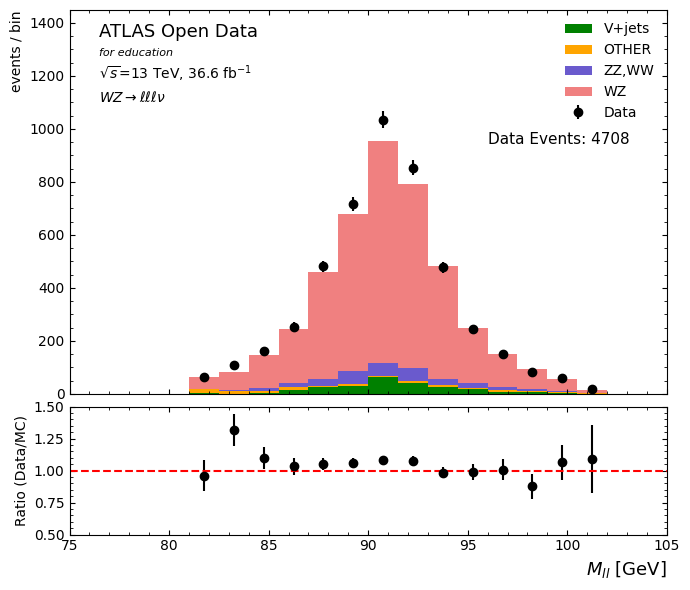

In [30]:
plot_data(
    np.hstack(all_data['Data']['zmass']), 75, 105, 1.5, r"$M_{ll}$ [GeV]", "events / bin",
    np.hstack(all_data['Signal']['zmass']), np.hstack(all_data['Signal']['totalWeight']),
    np.hstack(all_data['Diboson']['zmass']), np.hstack(all_data['Diboson']['totalWeight']),
    np.hstack(all_data['Vjets']['zmass']), np.hstack(all_data['Vjets']['totalWeight']),
    np.hstack(all_data['other']['zmass']), np.hstack(all_data['other']['totalWeight'])
)


6. **Z Boson Mass from Muon Pairs ($μμ$)**:
  - Variable: "mumu_mass"
  - Range: [75, 105] GeV, 1.5 GeV bins
  - X-axis: "$M_{μμ}$ [GeV]"

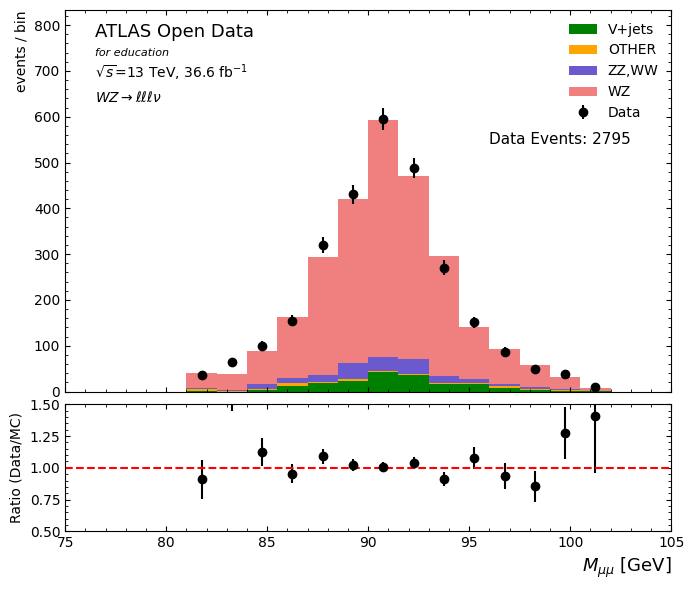

In [31]:
plot_data(
    np.hstack(all_data['Data']['mumu_pair_mass']), 75, 105, 1.5, r"$M_{μμ}$ [GeV]", "events / bin",
    np.hstack(all_data['Signal']['mumu_pair_mass']), np.hstack(all_data['Signal']['totalWeight']),
    np.hstack(all_data['Diboson']['mumu_pair_mass']), np.hstack(all_data['Diboson']['totalWeight']),
    np.hstack(all_data['Vjets']['mumu_pair_mass']), np.hstack(all_data['Vjets']['totalWeight']),
    np.hstack(all_data['other']['mumu_pair_mass']), np.hstack(all_data['other']['totalWeight'])
)

7. **Z Boson Mass from Electron Pairs ($ee$)**:
  - Variable: "ee_mass"
  - Range: [75, 105] GeV, 1.5 GeV bins
  - X-axis: "$M_{ee}$ [GeV]"

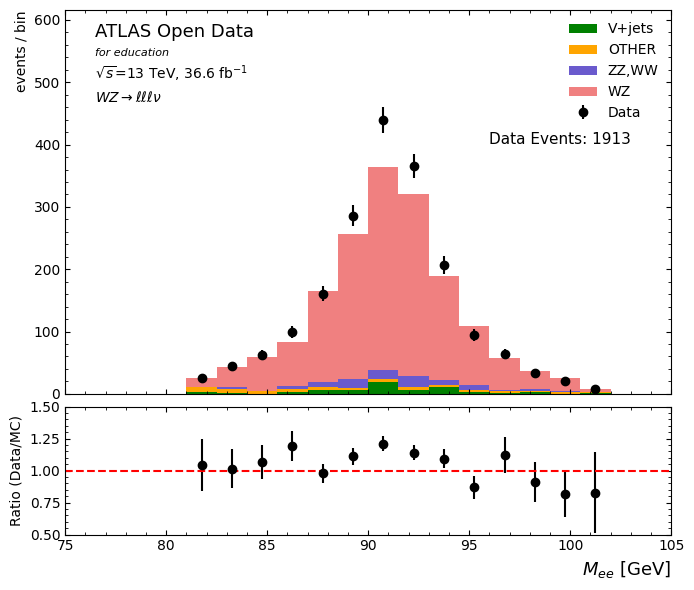

In [32]:
plot_data(
    np.hstack(all_data['Data']['ee_pair_mass']), 75, 105, 1.5, r"$M_{ee}$ [GeV]", "events / bin",
    np.hstack(all_data['Signal']['ee_pair_mass']), np.hstack(all_data['Signal']['totalWeight']),
    np.hstack(all_data['Diboson']['ee_pair_mass']), np.hstack(all_data['Diboson']['totalWeight']),
    np.hstack(all_data['Vjets']['ee_pair_mass']), np.hstack(all_data['Vjets']['totalWeight']),
    np.hstack(all_data['other']['ee_pair_mass']), np.hstack(all_data['other']['totalWeight'])
)